# Goal:
Generate career success labels for each NBA player to generate our model target variable.

## Import packages

In [1]:
! pip install lifelines yellowbrick
import pandas as pd
import numpy as np
import getpass
import psycopg2
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import minmax_scale, StandardScaler, QuantileTransformer
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
sns.set_style('whitegrid')
sns.set(rc = {'figure.figsize':(12, 8)})

# Import data

In [2]:
mypasswd = getpass.getpass()
conn = psycopg2.connect(database = 'cs20_group4',
                              user = 'jpcp73', #replace with pawprint
                              host = 'pgsql.dsa.lan',
                              password = mypasswd)
cursor = conn.cursor()

········


We want to compile a wide variety of statistics for as many individual seasons as possible to use in our analyses.

In [3]:
data = pd.read_sql_query("""
SELECT
    nba.player_id
    , nba.player_name
    , nba.team_abbreviation as team
    , nba.season
    , nba.height
    , nba.weight
    , nba.height / nba.weight as height_to_weight
    , nba.height - hw.avg_height as relative_height
    , nba.weight - hw.avg_weight as relative_weight
    , nba.position
    , nba.assists
    , nba.assist_percentage
    , nba.blocks
    , nba.block_percentage
    , nba.box_plus_minus
    , nba.defensive_box_plus_minus
    , nba.defensive_rebound_percentage
    , nba.defensive_rebounds
    , nba.defensive_win_shares
    , nba.effective_field_goal_percentage
    , nba.field_goal_attempts
    , nba.field_goal_percentage
    , nba.field_goals
    , nba.free_throw_attempt_rate
    , nba.free_throw_attempts
    , nba.free_throw_percentage
    , nba.free_throws
    , nba.games_played
    , nba.minutes_played
    , CASE
        WHEN nba.nationality = 'United States of America'
            THEN 0
            ELSE 1
        END as foreign_born
    , nba.offensive_box_plus_minus
    , nba.offensive_rebound_percentage
    , nba.offensive_rebounds
    , nba.offensive_win_shares
    , nba.personal_fouls
    , nba.player_efficiency_rating
    , nba.points
    , nba.steal_percentage
    , nba.steals
    , nba.three_point_attempts
    , nba.three_point_percentage
    , nba.three_pointers
    , nba.total_rebound_percentage
    , nba.total_rebounds
    , nba.true_shooting_percentage
    , nba.turnovers
    , nba.two_point_attempts
    , nba.two_point_percentage
    , nba.two_pointers
    , nba.usage_percentage
    , nba.value_over_replacement_player as vorp
    , nba.win_shares
    , nba.win_shares_per_48_minutes
    , nba.age
    , CASE
        WHEN cr.player_id IS NULL
            THEN 1
            ELSE 0
        END as out_of_league
    , min.assists_per_minute
    , min.blocks_per_minute
    , min.defensive_rebounds_per_minute
    , min.field_goal_attempts_per_minute
    , min.field_goals_made_per_minute
    , min.free_throw_attempts_per_minute
    , min.free_throws_made_per_minute
    , min.offensive_rebounds_per_minute
    , min.personal_fouls_per_minute
    , min.points_per_minute
    , min.steals_per_minute
    , min.three_point_attempts_per_minute
    , min.three_pointers_made_per_minute
    , min.total_rebounds_per_minute
    , min.turnovers_per_minute
    , min.two_point_attempts_per_minute
    , min.two_pointers_made_per_minute
    , min.win_shares_per_minute
FROM nba_player_season_totals nba
JOIN nba_player_per_minute_stats_season min ON nba.player_id = min.player_id
                                                AND nba.season = min.season
LEFT JOIN nba_current_rosters cr ON nba.player_id = cr.player_id
LEFT JOIN (
    SELECT
        nba.season
        , AVG(nba.height) as avg_height
        , AVG(nba.weight) as avg_weight
    FROM nba_player_season_totals nba
    GROUP BY nba.season) hw ON nba.season = hw.season
WHERE nba.games_played IS NOT NULL
    AND nba.minutes_played IS NOT NULL
    --AND nba.season >= 1980
""", con = conn)
print(data.shape)
data.head()

(21516, 73)


,player_id,player_name,team,season,height,weight,height_to_weight,relative_height,relative_weight,position,assists,assist_percentage,blocks,block_percentage,box_plus_minus,defensive_box_plus_minus,defensive_rebound_percentage,defensive_rebounds,defensive_win_shares,effective_field_goal_percentage,field_goal_attempts,field_goal_percentage,field_goals,free_throw_attempt_rate,free_throw_attempts,free_throw_percentage,free_throws,games_played,minutes_played,foreign_born,offensive_box_plus_minus,offensive_rebound_percentage,offensive_rebounds,offensive_win_shares,personal_fouls,player_efficiency_rating,points,steal_percentage,steals,three_point_attempts,three_point_percentage,three_pointers,total_rebound_percentage,total_rebounds,true_shooting_percentage,turnovers,two_point_attempts,two_point_percentage,two_pointers,usage_percentage,vorp,win_shares,win_shares_per_48_minutes,age,out_of_league,assists_per_minute,blocks_per_minute,defensive_rebounds_per_minute,field_goal_attempts_per_minute,field_goals_made_per_minute,free_throw_attempts_per_minute,free_throws_made_per_minute,offensive_rebounds_per_minute,personal_fouls_per_minute,points_per_minute,steals_per_minute,three_point_attempts_per_minute,three_pointers_made_per_minute,total_rebounds_per_minute,turnovers_per_minute,two_point_attempts_per_minute,two_pointers_made_per_minute,win_shares_per_minute
0,willima02,Marvin Williams,ATL,2009.0,81.0,237.0,0.341772,1.874730,15.673866,PF,81.0,0.063,39.0,0.014,0.9,0.1,0.152,272.0,2.2,0.502,622.0,0.458,285.0,0.439,273.0,0.806,220.0,61.0,2093.0,0,0.8,0.062,110.0,3.9,127.0,16.0,845.0,0.015,57.0,155.0,0.355,55.0,0.107,382.0,0.569,70.0,467.0,0.493,230.0,0.182,1.5,6.1,0.140,22.538450,0,0.038700,0.018634,0.129957,0.297181,0.136168,0.130435,0.105112,0.052556,0.060678,0.403727,0.027234,0.074056,0.026278,0.182513,0.033445,0.223125,0.109890,0.002914
1,willima02,Marvin Williams,ATL,2011.0,81.0,237.0,0.341772,1.774892,13.114719,PF,88.0,0.076,23.0,0.009,-1.3,-0.4,0.157,245.0,1.7,0.493,537.0,0.458,246.0,0.324,174.0,0.845,147.0,65.0,1865.0,0,-0.9,0.044,68.0,2.3,104.0,13.5,676.0,0.010,34.0,110.0,0.336,37.0,0.101,313.0,0.551,62.0,427.0,0.489,209.0,0.172,0.3,4.0,0.102,24.537123,0,0.047185,0.012332,0.131367,0.287936,0.131903,0.093298,0.078820,0.036461,0.055764,0.362466,0.018231,0.058981,0.019839,0.167828,0.033244,0.228954,0.112064,0.002145
2,willima02,Marvin Williams,UTA,2014.0,81.0,237.0,0.341772,1.894000,14.808000,PF,78.0,0.077,31.0,0.015,0.2,-0.3,0.179,252.0,1.0,0.519,526.0,0.439,231.0,0.139,73.0,0.781,57.0,66.0,1674.0,0,0.5,0.055,82.0,1.9,151.0,14.0,603.0,0.017,54.0,234.0,0.359,84.0,0.115,334.0,0.540,53.0,292.0,0.503,147.0,0.167,0.9,2.9,0.084,27.537869,0,0.046595,0.018519,0.150538,0.314217,0.137993,0.043608,0.034050,0.048984,0.090203,0.360215,0.032258,0.139785,0.050179,0.199522,0.031661,0.174432,0.087814,0.001732
3,willima02,Marvin Williams,CHO,2017.0,81.0,237.0,0.341772,1.878731,16.438433,PF,106.0,0.071,53.0,0.020,0.2,0.5,0.198,411.0,2.6,0.510,704.0,0.422,297.0,0.213,150.0,0.873,131.0,76.0,2295.0,0,-0.3,0.042,89.0,2.4,134.0,13.7,849.0,0.013,58.0,354.0,0.350,124.0,0.120,500.0,0.551,60.0,350.0,0.494,173.0,0.163,1.3,5.0,0.105,30.538615,0,0.046187,0.023094,0.179085,0.306754,0.129412,0.065359,0.057081,0.038780,0.058388,0.369935,0.025272,0.154248,0.054031,0.217865,0.026144,0.152505,0.075381,0.002179
4,hewitbi01,Bill Hewitt,DET,1972.0,79.0,210.0,0.376190,1.116608,4.745583,PF,71.0,0.077,NaN,NaN,NaN,NaN,NaN,NaN,0.2,NaN,277.0,0.473,131.0,0.296,82.0,0.500,41.0,68.0,1203.0,0,NaN,NaN,NaN,0.4,134.0,10.5,303.0,NaN,NaN,NaN,NaN,NaN,0.146,370.0,0.484,NaN,NaN,NaN,NaN,NaN,NaN,0.6,0.023,27.398235,1,0.059019,NaN,NaN,0.230258,0.108894,0.068163,0.034081,NaN,0.111388,0.251870,NaN,NaN,NaN,0.307564,NaN,NaN,NaN,0.000499


Create lists of various column types so they are easy to reference later on.

In [4]:
numeric_cols = data.select_dtypes([int, float]).columns.to_list()
other_cols = [x for x in data.columns if not x in numeric_cols]

In [5]:
adv_metrics = ['box_plus_minus', 'defensive_box_plus_minus', 'defensive_win_shares', 'offensive_box_plus_minus',
              'offensive_win_shares', 'player_efficiency_rating', 'vorp', 'win_shares',
              'win_shares_per_48_minutes', 'win_shares_per_minute']
trad_metrics = [x for x in numeric_cols if not x in adv_metrics]

In [6]:
defense_cols = ['blocks', 'block_percentage', 'defensive_box_plus_minus', 'defensive_rebound_percentage',
               'defensive_rebounds', 'defensive_win_shares', 'personal_fouls', 'steal_percentage', 'steals',
               'blocks_per_minute', 'defensive_rebounds_per_minute', 'personal_fouls_per_minute']
offense_cols = ['assists', 'assist_percentage', 'effective_field_goal_percentage', 'field_goal_attempts',
               'field_goal_percentage', 'field_goals', 'free_throw_attempt_rate', 'free_throw_attempts',
               'free_throw_percentage', 'free_throws', 'offensive_box_plus_minus', 'offensive_rebound_percentage',
               'offensive_rebounds', 'offensive_win_shares', 'points', 'three_point_attempts',
               'three_point_percentage', 'three_pointers', 'true_shooting_percentage', 'turnovers',
               'two_point_attempts', 'two_point_percentage', 'two_pointers', 'usage_percentage',
               'assists_per_minute', 'field_goal_attempts_per_minute', 'field_goals_made_per_minute',
               'free_throw_attempts_per_minute', 'free_throws_made_per_minute', 'offensive_rebounds_per_minute',
               'points_per_minute', 'steals_per_minute', 'three_point_attempts_per_minute', 
               'three_pointers_made_per_minute', 'turnovers_per_minute', 'two_point_attempts_per_minute',
               'two_pointers_made_per_minute']

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21516 entries, 0 to 21515
Data columns (total 73 columns):
player_id                          21516 non-null object
player_name                        21516 non-null object
team                               21516 non-null object
season                             21516 non-null float64
height                             21516 non-null float64
weight                             21516 non-null float64
height_to_weight                   21516 non-null float64
relative_height                    21516 non-null float64
relative_weight                    21516 non-null float64
position                           18015 non-null object
assists                            21516 non-null float64
assist_percentage                  20149 non-null float64
blocks                             18372 non-null float64
block_percentage                   18369 non-null float64
box_plus_minus                     18363 non-null float64
defensive_box_plus_minus 

# Player longevity

## By seasons in NBA

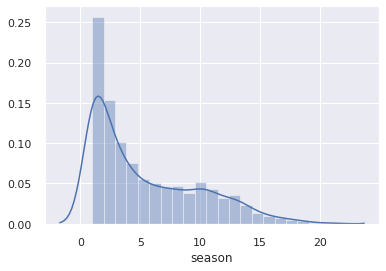

In [8]:
sns.distplot(data.groupby(['player_id']).season.nunique(),
            bins = data.groupby(['player_id']).season.nunique().max().astype(int));

## By age

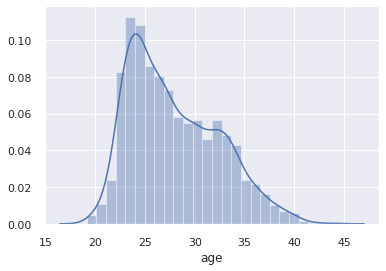

In [9]:
sns.distplot(data.groupby(['player_id']).age.max(),
            bins = (data.age.max().astype(int) - data.age.min().astype(int)));

# Survival Analysis

To prevent the overweighting of small sample sizes in our analysis, we want to have a better idea how long the average player is able to stay in the league. Given that there are hundreds of players in our data whose careers are ongoing, those estimates are fairly heavily censored. Using Kaplan-Meier estimates will allow us to make more educated guesses on those breakpoints.

In [10]:
car_len = data.groupby('player_id').agg({'season' : 'nunique',
                                         'out_of_league' : 'max',
                                         'age' : 'max'}).rename(columns = {'season' : 'years_in_nba',
                                                                          'age' : 'max_age'}).reset_index()
print(car_len.shape)
car_len.head()

(4014, 4)


,player_id,years_in_nba,out_of_league,max_age
0,abdelal01,5,1,26.522105
1,abdulka01,20,1,41.714751
2,abdulma01,10,1,31.715915
3,abdulma02,9,1,31.817217
4,abdulta01,6,1,28.162111


## Survival estimate by years in NBA

The average play only sticks around for about four seasons in the NBA.

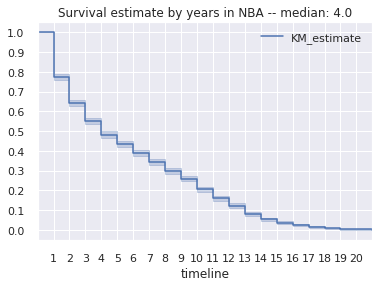

In [11]:
kmf_years = KaplanMeierFitter().fit(car_len.years_in_nba, car_len.out_of_league)
kmf_years.plot()
plt.xticks(np.arange(1, car_len.years_in_nba.max().astype(int), 1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title('Survival estimate by years in NBA -- median: {}'.format(kmf_years.median_survival_time_));

## Survival estimate by age

The average player is able to stay in the league until they're 27 or 28 years old.

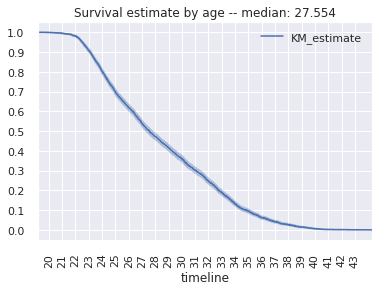

In [12]:
kmf_age = KaplanMeierFitter().fit(car_len.max_age, car_len.out_of_league)
kmf_age.plot()
plt.xticks(np.arange(car_len.max_age.min().astype(int), car_len.max_age.max().astype(int), 1), rotation = 90)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlim(car_len.max_age.min(), car_len.max_age.max())
plt.title('Survival estimate by age -- median: {}'.format(round(kmf_age.median_survival_time_, 3)));

# Fill missing values

In [13]:
data.three_point_attempts.fillna(0, inplace = True)
data.three_point_attempts_per_minute.fillna(0, inplace = True)
data.three_point_percentage.fillna(0, inplace = True)
data.three_pointers.fillna(0, inplace = True)
data.three_pointers_made_per_minute.fillna(0, inplace = True)
data.defensive_rebounds.fillna(data.total_rebounds * (data.loc[data.defensive_rebounds.notnull()].defensive_rebounds.sum() / data.loc[data.defensive_rebounds.notnull()].total_rebounds.sum()), inplace = True)
data.offensive_rebounds.fillna(data.total_rebounds * (data.loc[data.offensive_rebounds.notnull()].offensive_rebounds.sum() / data.loc[data.offensive_rebounds.notnull()].total_rebounds.sum()), inplace = True)
data.defensive_rebounds_per_minute.fillna(data.defensive_rebounds / data.minutes_played, inplace = True)
data.offensive_rebounds_per_minute.fillna(data.offensive_rebounds / data.minutes_played, inplace = True)

# Aggregate each player's average/median across each statistic

In [14]:
off = data.loc[data.minutes_played >= data.minutes_played.quantile(0.1)].dropna().groupby(['player_id',
                                                                                          'player_name']).agg({#'height' : 'mean',
                                                                                                               #'weight' : 'mean',
                                                                                                               #'relative_height' : 'mean',
                                                                                                               #'relative_weight' : 'mean',
                                                                                                               'assists' : 'mean',
                                                                                                               'assist_percentage' : 'median',
                                                                                                               'effective_field_goal_percentage' : 'median',
                                                                                                               'field_goal_attempts' : 'mean',
                                                                                                               'field_goal_percentage' : 'median',
                                                                                                               'field_goals' : 'mean',
                                                                                                               'free_throw_attempt_rate' : 'median',
                                                                                                               'free_throw_attempts' : 'mean',
                                                                                                               'free_throw_percentage' : 'median',
                                                                                                               'free_throws' : 'mean',
                                                                                                               'offensive_box_plus_minus' : 'mean',
                                                                                                               'offensive_rebound_percentage' : 'median',
                                                                                                               'offensive_rebounds' : 'mean',
                                                                                                               'offensive_win_shares' : 'mean',
                                                                                                               'points' : 'mean',
                                                                                                               'three_point_attempts' : 'mean',
                                                                                                               'three_point_percentage' : 'median',
                                                                                                               'three_pointers' : 'mean',
                                                                                                               'true_shooting_percentage' : 'median',
                                                                                                               'turnovers' : 'mean',
                                                                                                               'two_point_attempts' : 'mean',
                                                                                                               'two_point_percentage' : 'median',
                                                                                                               'two_pointers' : 'mean',
                                                                                                               'usage_percentage' : 'median',
                                                                                                               'assists_per_minute' : 'median',
                                                                                                               'field_goal_attempts_per_minute' : 'median',
                                                                                                               'field_goals_made_per_minute' : 'median',
                                                                                                               'free_throw_attempts_per_minute' : 'median',
                                                                                                               'free_throws_made_per_minute' : 'median',
                                                                                                               'offensive_rebounds_per_minute' : 'median',
                                                                                                               'points_per_minute' : 'median',
                                                                                                               'steals_per_minute' : 'median',
                                                                                                               'three_point_attempts_per_minute' : 'median',
                                                                                                               'three_pointers_made_per_minute' : 'median',
                                                                                                               'turnovers_per_minute' : 'median',
                                                                                                               'two_point_attempts_per_minute' : 'median',
                                                                                                               'two_pointers_made_per_minute' : 'median'}).reset_index()
print(off.shape)
off.head()

(2237, 39)


,player_id,player_name,assists,assist_percentage,effective_field_goal_percentage,field_goal_attempts,field_goal_percentage,field_goals,free_throw_attempt_rate,free_throw_attempts,free_throw_percentage,free_throws,offensive_box_plus_minus,offensive_rebound_percentage,offensive_rebounds,offensive_win_shares,points,three_point_attempts,three_point_percentage,three_pointers,true_shooting_percentage,turnovers,two_point_attempts,two_point_percentage,two_pointers,usage_percentage,assists_per_minute,field_goal_attempts_per_minute,field_goals_made_per_minute,free_throw_attempts_per_minute,free_throws_made_per_minute,offensive_rebounds_per_minute,points_per_minute,steals_per_minute,three_point_attempts_per_minute,three_pointers_made_per_minute,turnovers_per_minute,two_point_attempts_per_minute,two_pointers_made_per_minute
0,abdelal01,Alaa Abdelnaby,17.000000,0.0470,0.4930,247.200000,0.4930,124.000000,0.2800,64.200000,0.640,45.000000,-4.240000,0.095,56.600000,0.140000,293.000000,0.600000,0.00,0.000000,0.5190,49.400000,246.600000,0.4930,124.000000,0.2210,0.025692,0.386510,0.189655,0.108137,0.081370,0.086724,0.462527,0.019069,0.000000,0.000000,0.075862,0.386510,0.189655
1,abdulka01,Kareem Abdul-Jabbar,243.333333,0.1250,0.5755,1188.250000,0.5755,677.750000,0.3275,389.166667,0.744,290.166667,2.733333,0.075,163.000000,6.633333,1645.750000,1.500000,0.00,0.083333,0.6080,210.583333,1186.750000,0.5755,677.666667,0.2445,0.087724,0.465547,0.273989,0.150229,0.110217,0.063260,0.657270,0.023709,0.000407,0.000000,0.080989,0.465166,0.273989
2,abdulma02,Mahmoud Abdul-Rauf,231.000000,0.2100,0.4760,882.555556,0.4450,390.444444,0.1470,129.000000,0.885,116.777778,0.333333,0.015,24.333333,1.877778,950.333333,148.777778,0.33,52.666667,0.5150,107.000000,733.777778,0.4650,337.777778,0.2550,0.126937,0.506173,0.226705,0.070221,0.061118,0.012814,0.547325,0.030996,0.066445,0.020156,0.057157,0.446494,0.207749
3,abernto01,Tom Abernethy,71.500000,0.0885,0.4895,280.750000,0.4895,138.750000,0.2750,77.250000,0.714,57.500000,-0.625000,0.068,65.250000,1.650000,335.000000,0.500000,0.00,0.000000,0.5275,32.250000,280.250000,0.4905,138.750000,0.1355,0.068001,0.270393,0.134793,0.075469,0.051625,0.063910,0.321211,0.030318,0.000409,0.000000,0.029380,0.269984,0.134793
4,abrinal01,Álex Abrines,29.333333,0.0430,0.5310,263.000000,0.3930,101.666667,0.1440,36.000000,0.898,31.666667,-1.066667,0.019,16.333333,0.866667,308.000000,198.333333,0.38,73.000000,0.5600,24.000000,64.666667,0.4430,28.666667,0.1270,0.034014,0.267007,0.101411,0.040564,0.034392,0.017062,0.311287,0.033510,0.215986,0.074074,0.023810,0.061728,0.027337


In [15]:
def_data = data.loc[data.minutes_played >= data.minutes_played.quantile(0.1)].dropna().groupby(['player_id',
                                                                                          'player_name']).agg({#'height' : 'mean',
                                                                                                               #'weight' : 'mean',
                                                                                                               #'relative_height' : 'mean',
                                                                                                               #'relative_weight' : 'mean',
                                                                                                               'blocks' : 'mean',
                                                                                                               'block_percentage' : 'median',
                                                                                                               'defensive_box_plus_minus' : 'mean',
                                                                                                               'defensive_rebound_percentage' : 'median',
                                                                                                               'defensive_rebounds' : 'mean',
                                                                                                               'defensive_win_shares' : 'mean',
                                                                                                               'personal_fouls' : 'mean',
                                                                                                               'steal_percentage' : 'median',
                                                                                                               'steals' : 'mean',
                                                                                                               'blocks_per_minute' : 'median',
                                                                                                               'defensive_rebounds_per_minute' : 'median',
                                                                                                               'personal_fouls_per_minute' : 'median'}).reset_index()
print(def_data.shape)
def_data.head()

(2237, 14)


,player_id,player_name,blocks,block_percentage,defensive_box_plus_minus,defensive_rebound_percentage,defensive_rebounds,defensive_win_shares,personal_fouls,steal_percentage,steals,blocks_per_minute,defensive_rebounds_per_minute,personal_fouls_per_minute
0,abdelal01,Alaa Abdelnaby,13.800000,0.012,-1.660000,0.209,112.600000,0.820000,96.800000,0.0100,14.200000,0.019832,0.191649,0.141328
1,abdulka01,Kareem Abdul-Jabbar,174.583333,0.034,1.241667,0.179,487.500000,3.691667,222.500000,0.0110,63.583333,0.064080,0.170655,0.084908
2,abdulma02,Mahmoud Abdul-Rauf,5.111111,0.002,-3.377778,0.060,96.444444,0.933333,122.888889,0.0150,54.111111,0.002658,0.055200,0.066052
3,abernto01,Tom Abernethy,12.500000,0.006,-0.075000,0.120,114.750000,0.900000,101.750000,0.0145,34.000000,0.010366,0.111027,0.102834
4,abrinal01,Álex Abrines,7.333333,0.006,-1.600000,0.078,66.333333,0.833333,97.000000,0.0170,30.666667,0.007583,0.073129,0.108057


Denote columns we'll ultimately want to fit our PCA on.

In [16]:
fit_columns_off = [x for x in off.columns if x not in ['player_id', 'player_name']]
fit_columns_def = [x for x in def_data.columns if x not in ['player_id', 'player_name']]

Rescale the columns we'll be analyzing.

In [17]:
scaled_data_off = StandardScaler().fit_transform(off[fit_columns_off])
scaled_data_def = StandardScaler().fit_transform(def_data[fit_columns_def])

# PCA

We will be treating offensive and defensive data as separate analyses, and therefore creating different PCA components and K-Means clusters for each. First, we'll design a couple of functions to help determine how many components we need for each dataset.

## Offense

In [18]:
def pca_plot(data):
    pca = PCA().fit(data)
    evr = np.cumsum(pca.explained_variance_ratio_)
    components = 0
    for i in evr:
        while i < .9:
            components += 1
            break
    plot = plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative explained variance')
    plt.title('Threshold at {} components'.format(components))
    return plot

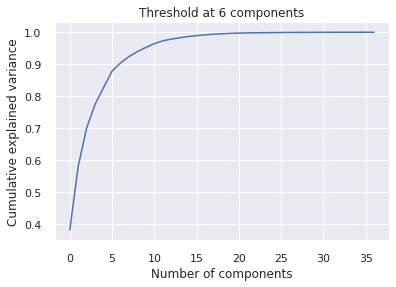

In [19]:
pca_plot(scaled_data_off);

## Defense

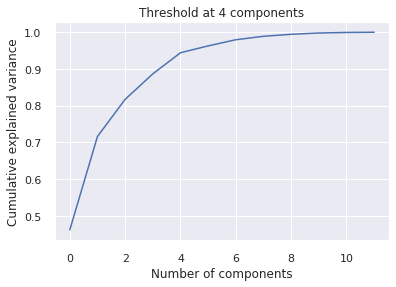

In [20]:
pca_plot(scaled_data_def);

In [21]:
def pca_components(data):
    pca = PCA().fit(data)
    evr = np.cumsum(pca.explained_variance_ratio_)
    components = 0
    for i in evr:
        while i < 0.9:
            components += 1
            break
    return components

# K-Means

Using the number of components specified above, we can use this KElbowVisualizer from the yellowbrick package to determine the appropriate number of clusters.

## Offense

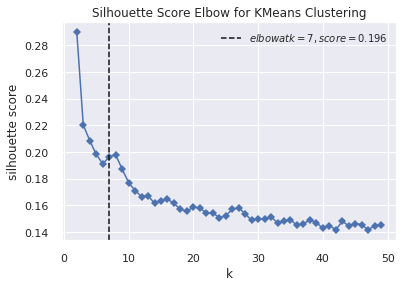

In [22]:
pca_off = PCA(n_components = pca_components(scaled_data_off))
km_off = KMeans(random_state = 0)
elbow_off = KElbowVisualizer(km_off, metric = 'silhouette', k = (2, 50), timings = False)
elbow_off.fit(pca_off.fit_transform(scaled_data_off))
elbow_off.poof();

## Defense

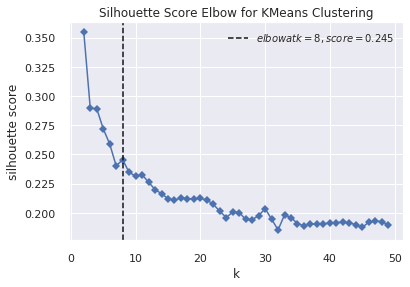

In [23]:
pca_def = PCA(n_components = pca_components(scaled_data_def))
km_def = KMeans(random_state = 0)
elbow_def = KElbowVisualizer(km_def, metric = 'silhouette', k = (2, 50), timings = False)
elbow_def.fit(pca_def.fit_transform(scaled_data_def))
elbow_def.poof();

In [24]:
kmeans_off = KMeans(n_clusters = elbow_off.elbow_value_, random_state = 0)
kmeans_def = KMeans(n_clusters = elbow_def.elbow_value_, random_state = 0)
off['cluster'] = kmeans_off.fit_predict(pca_off.fit_transform(scaled_data_off))
def_data['cluster'] = kmeans_def.fit_predict(pca_def.fit_transform(scaled_data_def))

## Categorizing each cluster

Now that we've created our clusters, we need to examine each and determine an appropriate description for each.

In [25]:
off.groupby('cluster').agg({'player_id' : 'nunique',
                           'field_goal_percentage' : 'median',
                           'three_point_percentage' : 'median',
                           'points_per_minute' : 'mean',
                           'assists_per_minute' : 'mean',
                           'offensive_rebounds_per_minute' : 'mean',
                           'offensive_box_plus_minus' : 'mean',
                           'offensive_win_shares' : 'mean'})

,player_id,field_goal_percentage,three_point_percentage,points_per_minute,assists_per_minute,offensive_rebounds_per_minute,offensive_box_plus_minus,offensive_win_shares
cluster,,,,,,,,
0,147,0.47200,0.25850,0.563260,0.126339,0.047151,1.558757,3.951159
1,408,0.41400,0.34275,0.341422,0.076999,0.030220,-1.579701,0.493809
2,247,0.43200,0.35500,0.435353,0.109533,0.026188,0.343643,1.990210
3,506,0.47800,0.00000,0.318856,0.042415,0.088622,-2.840095,0.495138
4,300,0.36400,0.19725,0.264769,0.082416,0.047615,-4.918025,-0.296213
5,272,0.48975,0.00000,0.449218,0.064084,0.077020,-0.923481,1.816899
6,357,0.43200,0.22200,0.380310,0.129333,0.037408,-2.345212,0.194095


This for loop allows us to see the best and worst player in each cluster.

In [26]:
for c in off.cluster.sort_values().unique():
    print('Cluster {}'.format(c))
    filt = off.loc[off.cluster == c]
    print(filt.loc[filt.offensive_win_shares.idxmax]['player_name'])
    print(filt.loc[filt.offensive_win_shares.idxmin]['player_name'])
    print('-------')

Cluster 0
Michael Jordan
Bird Averitt
-------
Cluster 1
Shane Battier
Frank Ntilikina
-------
Cluster 2
Ray Allen
Josh Jackson
-------
Cluster 3
Mitchell Robinson
Michael Olowokandi
-------
Cluster 4
Kevin Ollie
Del Beshore
-------
Cluster 5
Zelmo Beaty
Marcus Fizer
-------
Cluster 6
Brad Davis
Fatty Taylor
-------


After examining each cluster, we assign them with the following labels.

In [27]:
off_dict = {0 : 'Offensive centerpiece',
           1 : 'Floor spacer',
           2 : 'Secondary creator',
           3 : 'Rim runner',
           4 : 'Replacement player',
           5 : 'Post threat',
           6 : 'Pass-first'}

In [28]:
off['offensive_role'] = None
for i in range(len(off_dict)):
    off.loc[off.cluster == i, 'offensive_role'] = off_dict[i]
    
off.head()

,player_id,player_name,assists,assist_percentage,effective_field_goal_percentage,field_goal_attempts,field_goal_percentage,field_goals,free_throw_attempt_rate,free_throw_attempts,free_throw_percentage,free_throws,offensive_box_plus_minus,offensive_rebound_percentage,offensive_rebounds,offensive_win_shares,points,three_point_attempts,three_point_percentage,three_pointers,true_shooting_percentage,turnovers,two_point_attempts,two_point_percentage,two_pointers,usage_percentage,assists_per_minute,field_goal_attempts_per_minute,field_goals_made_per_minute,free_throw_attempts_per_minute,free_throws_made_per_minute,offensive_rebounds_per_minute,points_per_minute,steals_per_minute,three_point_attempts_per_minute,three_pointers_made_per_minute,turnovers_per_minute,two_point_attempts_per_minute,two_pointers_made_per_minute,cluster,offensive_role
0,abdelal01,Alaa Abdelnaby,17.000000,0.0470,0.4930,247.200000,0.4930,124.000000,0.2800,64.200000,0.640,45.000000,-4.240000,0.095,56.600000,0.140000,293.000000,0.600000,0.00,0.000000,0.5190,49.400000,246.600000,0.4930,124.000000,0.2210,0.025692,0.386510,0.189655,0.108137,0.081370,0.086724,0.462527,0.019069,0.000000,0.000000,0.075862,0.386510,0.189655,3,Rim runner
1,abdulka01,Kareem Abdul-Jabbar,243.333333,0.1250,0.5755,1188.250000,0.5755,677.750000,0.3275,389.166667,0.744,290.166667,2.733333,0.075,163.000000,6.633333,1645.750000,1.500000,0.00,0.083333,0.6080,210.583333,1186.750000,0.5755,677.666667,0.2445,0.087724,0.465547,0.273989,0.150229,0.110217,0.063260,0.657270,0.023709,0.000407,0.000000,0.080989,0.465166,0.273989,0,Offensive centerpiece
2,abdulma02,Mahmoud Abdul-Rauf,231.000000,0.2100,0.4760,882.555556,0.4450,390.444444,0.1470,129.000000,0.885,116.777778,0.333333,0.015,24.333333,1.877778,950.333333,148.777778,0.33,52.666667,0.5150,107.000000,733.777778,0.4650,337.777778,0.2550,0.126937,0.506173,0.226705,0.070221,0.061118,0.012814,0.547325,0.030996,0.066445,0.020156,0.057157,0.446494,0.207749,2,Secondary creator
3,abernto01,Tom Abernethy,71.500000,0.0885,0.4895,280.750000,0.4895,138.750000,0.2750,77.250000,0.714,57.500000,-0.625000,0.068,65.250000,1.650000,335.000000,0.500000,0.00,0.000000,0.5275,32.250000,280.250000,0.4905,138.750000,0.1355,0.068001,0.270393,0.134793,0.075469,0.051625,0.063910,0.321211,0.030318,0.000409,0.000000,0.029380,0.269984,0.134793,3,Rim runner
4,abrinal01,Álex Abrines,29.333333,0.0430,0.5310,263.000000,0.3930,101.666667,0.1440,36.000000,0.898,31.666667,-1.066667,0.019,16.333333,0.866667,308.000000,198.333333,0.38,73.000000,0.5600,24.000000,64.666667,0.4430,28.666667,0.1270,0.034014,0.267007,0.101411,0.040564,0.034392,0.017062,0.311287,0.033510,0.215986,0.074074,0.023810,0.061728,0.027337,1,Floor spacer


Repeat the same analysis as we did above, this time for defensive statistics.

In [29]:
def_data.groupby('cluster').agg({'player_id' : 'nunique',
                                'steals' : 'mean',
                                'blocks' : 'mean',
                                'defensive_box_plus_minus' : 'mean',
                                'defensive_win_shares' : 'mean'})

,player_id,steals,blocks,defensive_box_plus_minus,defensive_win_shares
cluster,,,,,
0,434,16.882052,4.004948,-2.172506,0.328497
1,168,19.237855,43.245154,1.331535,0.942472
2,174,100.781185,25.152825,0.377100,2.168838
3,392,14.143374,12.809800,-0.584116,0.520663
4,121,53.333609,101.681865,1.959139,2.849435
5,447,52.716513,14.117561,-1.078367,1.167559
6,257,24.188370,5.668319,-0.470496,0.445048
7,244,48.846468,37.292364,0.377494,1.844132


In [30]:
for c in def_data.cluster.sort_values().unique():
    print('Cluster {}'.format(c))
    filt = def_data.loc[def_data.cluster == c]
    print(filt.loc[filt.defensive_win_shares.idxmax]['player_name'])
    print(filt.loc[filt.defensive_win_shares.idxmin]['player_name'])
    print('-------')

Cluster 0
J.J. Redick
Collin Sexton
-------
Cluster 1
Chris Dudley
Sylvester Norris
-------
Cluster 2
Paul George
Kenny Higgs
-------
Cluster 3
Fabricio Oberto
Dan O'Sullivan
-------
Cluster 4
David Robinson
Thomas Bryant
-------
Cluster 5
Tony Parker
Cedi Osman
-------
Cluster 6
Ennis Whatley
Mickey Dillard
-------
Cluster 7
Truck Robinson
Cedrick Hordges
-------


In [31]:
def_dict = {0 : 'Perimeter liability',
           1 : 'Rim protector',
           2 : 'Perimeter stopper',
           3 : 'Interior liability',
           4 : 'Defensive centerpiece',
           5 : 'Secondary defender',
           6 : 'Replacement player',
           7 : 'Secondary defender'}

In [32]:
def_data['defensive_role'] = None
for i in range(len(def_dict)):
    def_data.loc[def_data.cluster == i, 'defensive_role'] = def_dict[i]
    
def_data.head()

,player_id,player_name,blocks,block_percentage,defensive_box_plus_minus,defensive_rebound_percentage,defensive_rebounds,defensive_win_shares,personal_fouls,steal_percentage,steals,blocks_per_minute,defensive_rebounds_per_minute,personal_fouls_per_minute,cluster,defensive_role
0,abdelal01,Alaa Abdelnaby,13.800000,0.012,-1.660000,0.209,112.600000,0.820000,96.800000,0.0100,14.200000,0.019832,0.191649,0.141328,3,Interior liability
1,abdulka01,Kareem Abdul-Jabbar,174.583333,0.034,1.241667,0.179,487.500000,3.691667,222.500000,0.0110,63.583333,0.064080,0.170655,0.084908,4,Defensive centerpiece
2,abdulma02,Mahmoud Abdul-Rauf,5.111111,0.002,-3.377778,0.060,96.444444,0.933333,122.888889,0.0150,54.111111,0.002658,0.055200,0.066052,5,Secondary defender
3,abernto01,Tom Abernethy,12.500000,0.006,-0.075000,0.120,114.750000,0.900000,101.750000,0.0145,34.000000,0.010366,0.111027,0.102834,5,Secondary defender
4,abrinal01,Álex Abrines,7.333333,0.006,-1.600000,0.078,66.333333,0.833333,97.000000,0.0170,30.666667,0.007583,0.073129,0.108057,0,Perimeter liability


Combine the offensive and defensive clusters for each player into a master table.

In [33]:
players = off[['player_id', 'player_name', 'offensive_role']].merge(def_data[['player_id', 'defensive_role']],
                                                                    on = 'player_id')
print(players.shape)
players.head()

(2237, 4)


,player_id,player_name,offensive_role,defensive_role
0,abdelal01,Alaa Abdelnaby,Rim runner,Interior liability
1,abdulka01,Kareem Abdul-Jabbar,Offensive centerpiece,Defensive centerpiece
2,abdulma02,Mahmoud Abdul-Rauf,Secondary creator,Secondary defender
3,abernto01,Tom Abernethy,Rim runner,Secondary defender
4,abrinal01,Álex Abrines,Floor spacer,Perimeter liability


In [34]:
players.groupby(['offensive_role', 'defensive_role']).player_id.nunique()

offensive_role         defensive_role       
Floor spacer           Interior liability        59
                       Perimeter liability      167
                       Perimeter stopper         15
                       Replacement player        40
                       Rim protector             10
                       Secondary defender       117
Offensive centerpiece  Defensive centerpiece     27
                       Perimeter liability        1
                       Perimeter stopper         47
                       Secondary defender        72
Pass-first             Defensive centerpiece      1
                       Interior liability        21
                       Perimeter liability      100
                       Perimeter stopper         36
                       Replacement player        98
                       Rim protector              2
                       Secondary defender        99
Post threat            Defensive centerpiece     61
                   

## Database Data Insertion

In [35]:
cursor = conn.cursor()

Define table schema for the `nba_player_clusters` table

In [36]:
create_table = """
DROP TABLE IF EXISTS nba_player_clusters;
CREATE TABLE nba_player_clusters(
player_id VARCHAR(100)
, player_name VARCHAR(250)
, offensive_role VARCHAR(100)
, defensive_role VARCHAR(100)
)
"""

In [37]:
cursor.execute(create_table)

In [38]:
conn.commit()

In [39]:
cursor = conn.cursor()

Insert our player cluster data into our `nba_player_clusters` data table.

In [40]:
df = players.where(pd.notnull(players), None)

INSERT_SQL = "INSERT INTO nba_player_clusters"
INSERT_SQL += "(player_id"
INSERT_SQL += ", player_name"
INSERT_SQL += ", offensive_role"
INSERT_SQL += ", defensive_role) VALUES"
INSERT_SQL += "(%s, %s, %s, %s)"

with conn, conn.cursor() as cursor:
    for row in df.itertuples(index=False, name=None):
        cursor.execute(INSERT_SQL,row)

Let's read from our `nba_player_clusters` data table and view the results.

In [41]:
test = pd.read_sql_query("""
SELECT
    *
FROM nba_player_clusters
""", con = conn)
print(test.shape)
test.head()

(2237, 4)


,player_id,player_name,offensive_role,defensive_role
0,abdelal01,Alaa Abdelnaby,Rim runner,Interior liability
1,abdulka01,Kareem Abdul-Jabbar,Offensive centerpiece,Defensive centerpiece
2,abdulma02,Mahmoud Abdul-Rauf,Secondary creator,Secondary defender
3,abernto01,Tom Abernethy,Rim runner,Secondary defender
4,abrinal01,Álex Abrines,Floor spacer,Perimeter liability
